### Statistical Data Analysis - Sheet 02 - Exercise 5

by Annika Bätz, baetz1@uni-potsdam.de

Suppose that you are running an advertising agency and you are interested in strategic result-oriented marketing by placing one of the 10 different advertisements at once to one user. The reward is 1 if the ad is clicked by the user, and 0 if not. Assume that the dataset 'Ads.csv' provided on Moodel is the underyling distribution of the rewards. 

In [1]:
import numpy as np
import csv
import pandas
from scipy.stats import beta
import matplotlib.pyplot as plt
import seaborn as sns
plt.style.use('seaborn')

In [2]:
df = pandas.read_csv('Ads.csv')

In [3]:
df.head()

,Ad 1,Ad 2,Ad 3,Ad 4,Ad 5,Ad 6,Ad 7,Ad 8,Ad 9,Ad 10
0,1,0,0,0,1,0,0,0,1,0
1,0,0,0,0,0,0,0,0,1,0
2,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,0,0,1,0,0
4,0,0,0,0,0,0,0,0,0,0


In [8]:
len(df)

10000

### Exercise 5.1

**Visualize the rewards distribution, i.e.g the number of being clicked by a user across all the advertisements. What do you observe?**

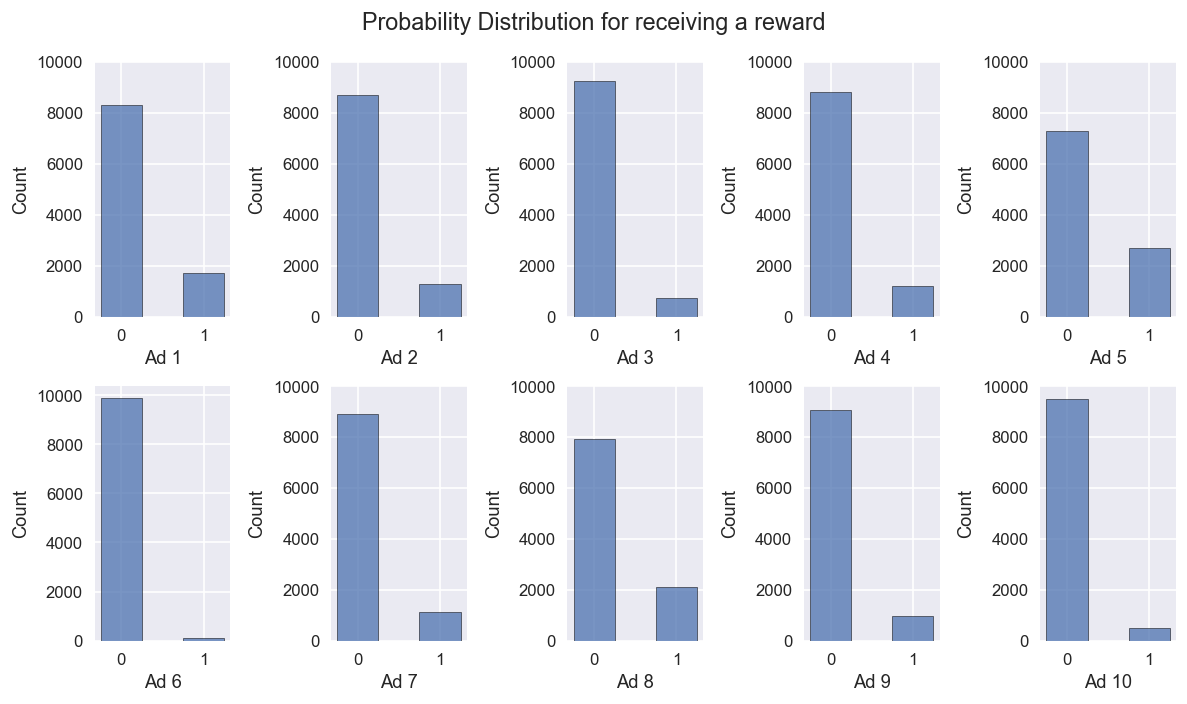

In [60]:
fig, axes = plt.subplots(2,5,figsize=(10,6),dpi=120)

for i, ax in enumerate(axes.flatten()):
    sns.histplot(df, x = df.columns[i], bins=[-0.25,0.25,0.75,1.25],ax = ax)
    ax.set_xticks([0,1])
    ax.set_yticks([0,2000,4000,6000,8000,10000])
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.suptitle('Probability Distribution for receiving a reward', fontsize=14, y=0.97)
plt.show()

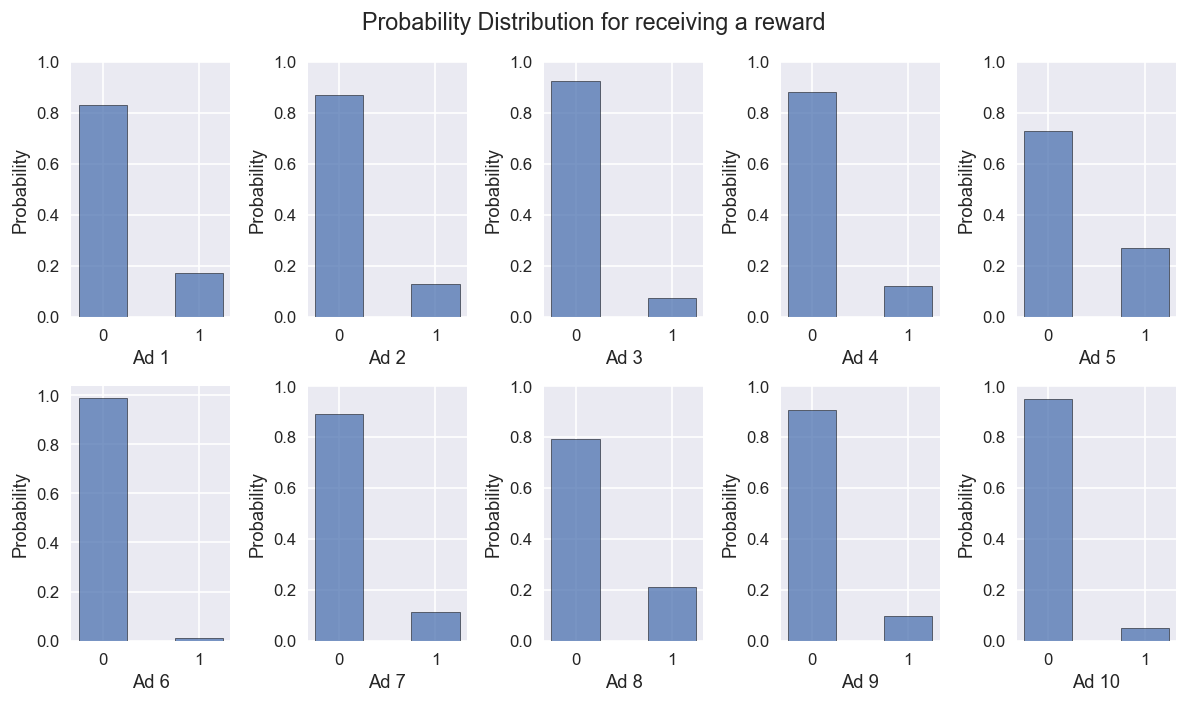

In [4]:
fig, axes = plt.subplots(2,5,figsize=(10,6),dpi=120)

for i, ax in enumerate(axes.flatten()):
    sns.histplot(df, x = df.columns[i], stat = 'probability', bins=[-0.25,0.25,0.75,1.25],ax = ax)
    ax.set_xticks([0,1])
    ax.set_yticks([0,0.2,0.4,0.6,0.8,1])
fig.tight_layout()
fig.subplots_adjust(top=0.9)
plt.suptitle('Probability Distribution for receiving a reward', fontsize=14, y=0.97)
plt.show()

The plot above shows:
* Across all ads the probability for receiving no reward is higher than for receiving a reward. 
* The ad with the lowest reward probability is 'Ad 6', the ad with the highest reward probability is 'Ad 5'.
* Even if we decide to use 'Ad 5', only in (roughly) approximately 1 of 4 cases the user will click on the ad. 

### Exercise 5.2

**Task: Implement Thompson sampling algorithm to maximize the cumulative rewards. Compute the total rewards you could achieve.** 

Notation: 

$A$ is the set of possible actions: $A$ = {1, 2, ..., 9, 10}
Each action corresponds to one specific ad. For example action '2' means: show 'Ad 2' to the user.

$Y$ is the set of possible outcomes: $Y$ = {$y_0$, $y_1$} = {'user doesn't click on ad', 'user clicks on ad'}. This set has kind of a 1-1-correspondence to the set of possible rewards R.

$R$ is set set of possible rewards: $R$ = {0, 1}:
* 0: reward when user didn't click on ad (outcome $y_0$)
* 1: reward when user clicked on ad (outcome $y_1$)

The outcome probabilities are given by the distributions represented in the plots. However, in general, these are obviously unkown and it is our task to explorate them by sampling and choosing wisely which ads to try out. 

We will use the Beta-Distribution to model the reward probabilities for our ten ads. Each time we make an observation (either a reward or not a reward) we can update the reward probabilty for the corresponding ad. First, all ads start with a priori proability that is given by the Beta-Distribution with a and b equal 1, i.e. a uniform distribution on [0,1].

In [5]:
def plot_beta(a,b,n_trials):
    x = np.linspace(0,1,100)
    fig, axes = plt.subplots(2,5,figsize=(12,6))

    for i, ax in enumerate(axes.flatten()):
        ax.plot(x, beta.pdf(x, a[i], b[i]))
        ax.set_xlim([0,1])
        ax.set_title('Ad '+str(i+1))
    fig.subplots_adjust(top=0.9)
    plt.suptitle('Beta Distributions after '+str(n_trials)+' samples', fontsize=14, y=0.97)
    fig.tight_layout()
    plt.show()

In [11]:
def thompson_sampling(create_plot=False):
    # save information about the choice of action we have taken and if a reward was received:
    # notation: to identify the ads we will use values between 1 and 10, not between 0 and 9!
    observations = []
    
    # initialize the beta distribution for all 10 ads with a = 1 and b = 1
    a = np.ones(10)
    b = np.ones(10)
    
    for index, row in df.iterrows():
        # sample from each beta distribution and choose the action/ad with the highest approximated probability
        # that the user will click on the ad: 
        samples = []
        for k in range(10):
            samples.extend([np.random.beta(a[k],b[k])])
        action = np.argmax(samples)
        # take the action and observe the reward
        reward = row[action]
        # save the observation
        observations.extend([[action+1,reward]])
        
        # update the beta-distribution for the ad that was tried out
        if reward == 1:
            a[action] += 1
        else:
            b[action] += 1
    
        if create_plot and (index+1 in [0,1,2,5,20,100,500,1000,10000]):
            plot_beta(a,b,index+1)
    return observations, a, b

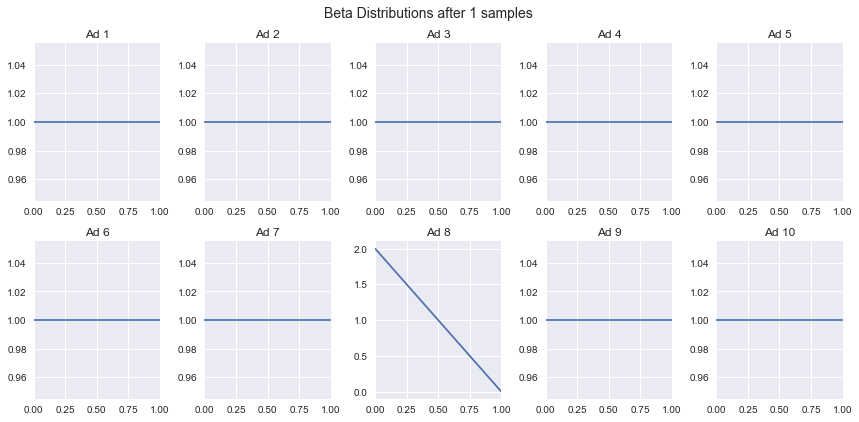

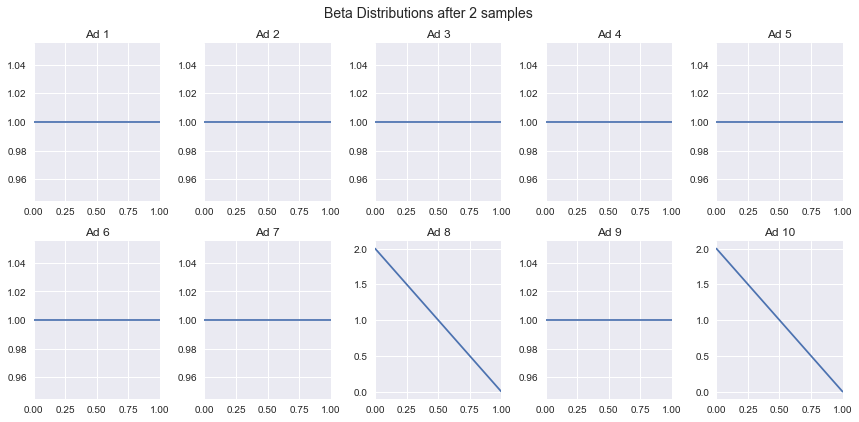

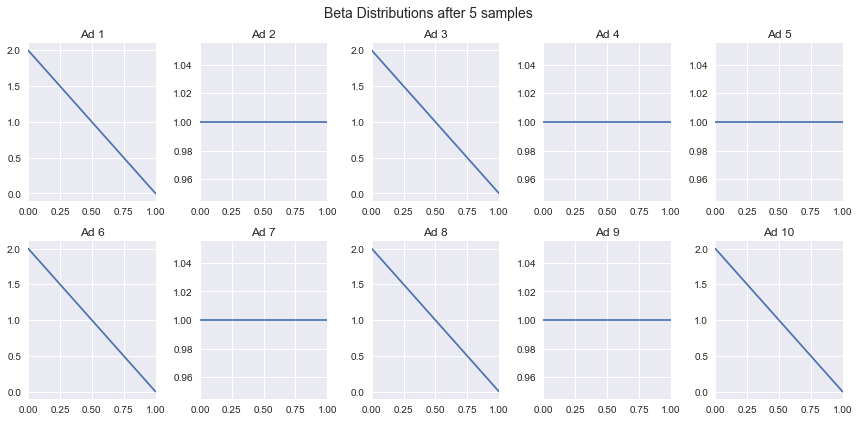

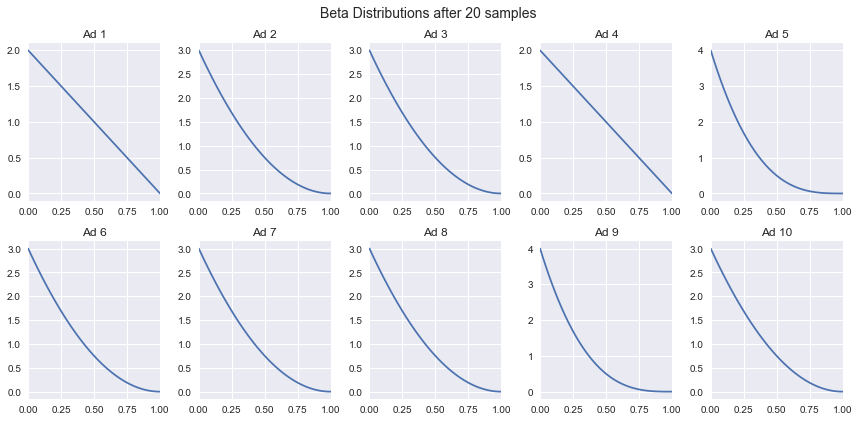

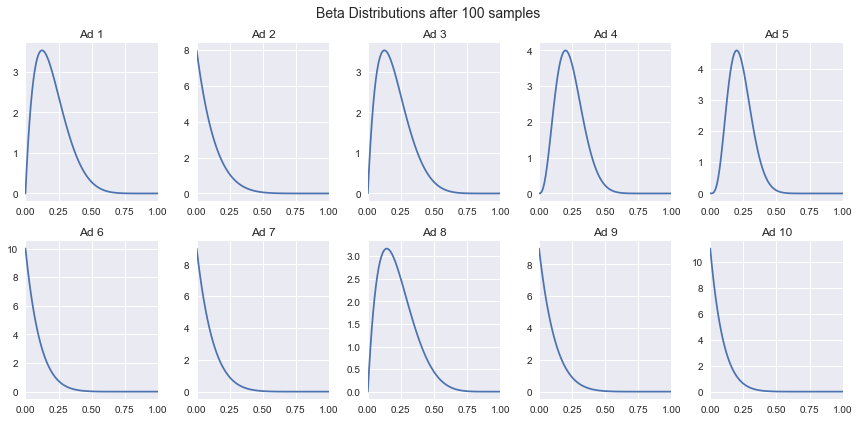

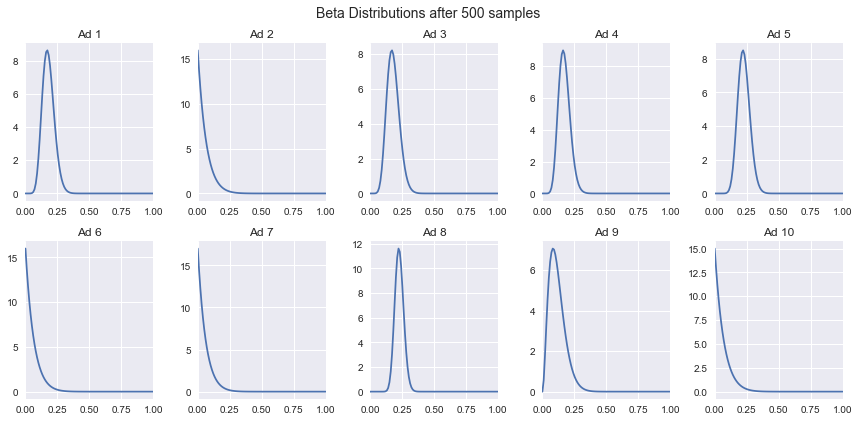

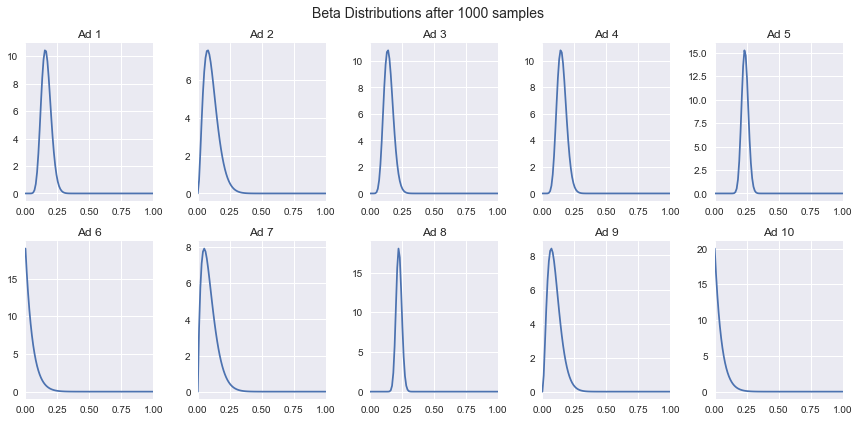

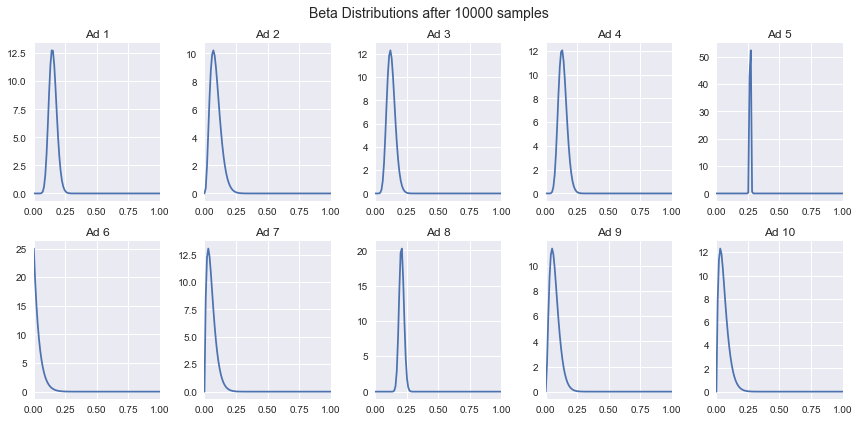

In [12]:
observations, a, b = thompson_sampling(create_plot=True)

After taking 10000 actions and updating the beta distributions after each observation of the reward, we can see a clear difference between the plots for the different ads. 
* For some ads the peak of the curve is at 0 or close to 0 (e.g. ad6 and ad10), i.e. according to our observations we can assume - with some certainty - that these ads have a low success/reward probability and it is very unlikely that the user will click on them. 
* The plots of ads 5 and 8 have very thin peaks. This indicates kind of a certainty, that the uccess/reward probabilities will be somewhere close to the peak, e.g. around 0.25 for ad5. The success/reward probability of curves with a wider peak (e.g. curve of ad 10) is more uncertain. This is due to the fact that the Thompson sampling favors ads whose reward probability is already expected to be higher. Thus, we will more often try out ad 5 and 8 than ad 10, and can approximate their success probability much better. 
* ad5 has the thinnest peak and the peak most to the right. This means that ad5 is probably our ad with the highest success probability.
* Let's take a look at the last 10 actions our algorithm took (see below). Our algorithm only chose ad5 at the end, because it was pretty sure about its high success probability. 

In [13]:
observations[-10:]

[[5, 0],
 [5, 1],
 [5, 0],
 [5, 1],
 [5, 0],
 [5, 0],
 [5, 0],
 [5, 0],
 [5, 0],
 [5, 0]]

**Compute the total rewards you could achieve.**

In [23]:
# All rewards we have observed:
observed_rewards = np.array(observations).T[1]
total_rewards = observed_rewards.sum()
print('Total rewards received during application of Thompson Sampling:', total_rewards)

Total rewards received during application of Thompson Sampling: 2570


In [27]:
# How many rewards could we have obtained by just using the best ad: ad5
potential_rewards_ad5 = df['Ad 5'].sum()
print('Total rewards we could have obtained if we had only used Ad 5:', potential_rewards_ad5)

Total rewards we could have obtained if we had only used Ad 5: 2695


### Exercise 5.3

**Task: Implement a function that computes the expected regret using the formula discussed in Lecture 4. Compute the regret.** 

Part 1: Compute the expected regret using the probability distributions derived from the provided table:

According to lecture the regret is defined as:

Regret(T) = $\sum_{t=1}^{T}(r(Y_t(a^*))-r(Y_t(a_t)))$

* $a_1, a_2, ..., a_T$ is the sequence of actions we have taken
* $Y_t(a)$ is a random variable. It describes the outcome of taking a specific action (the decision which ad to show) at time step t. This random variable takes either the "values" 'user clicks' or 'user doesn't click'.
* $Y(a)$ is a random variable we will use below. Because all $Y_t(a)$ for $t=1,2, ...$ are identically distributed, we will use $Y(a)$ instead.
* $r(...)$ is the reward that follows from an outcome, i.e. 1 if user clicks and 0 if user doens't click
* $a^*$ is the optimal action that corresponds to the highest expected reward. In our case this is "show ad 5", since it has the highest probability that a user will click on it.

From this formula we can derive the expected reward by using the 'Linearity of expectation'. Moreover, we can replace $Y_t$ by $Y$.

E[Regret(T)] = $\sum_{t=1}^{T} E[r(Y_t(a^*))] - \sum_{t=1}^{T} E[r(Y_t(a_t))] = T * E[r(Y(a^*))] - \sum_{t=1}^{T} E[r(Y(a_t))]$ 

In order to compute the expected regret we need the probability distributions $Y(a)$ for all our 10 possible actions/ads. Because there are only two possible outcomes (0 and 1), all $Y(a)$ ($Y('ad1'), Y('ad2'), ...$) follow a Bernoulli distribution and we just have to find the parameters p that give us the respective success probabilities:

In [30]:
p = df.mean().values
p

array([0.1703, 0.1295, 0.0728, 0.1196, 0.2695, 0.0126, 0.1112, 0.2091,
       0.0952, 0.0489])

In our example those p values are also our expected rewards $E[r(Y(a_t))]$ for the 10 possible actions.

$E[r(Y(a^*))]$ is given by the expected reward when taking ad 5:  $E[r(Y(a^*))] = 0.2695$. 

Now we can define our function that can compute the expected reward:

In [41]:
def expected_regret(actions_obs, optimal_action, expected_rewards):
    # compute the expected reward for a given sequence of actions
    # actions_obs: sequence of values between 1 and 10 that indicate which actions were taken
    # optimal_action: ad with highest probability that a user will click on it, i.e. action with highest success probability
    # expected_rewards: expected rewards for all possible actions to take
    T = len(actions_obs)
    sub = 0
    for a in actions_obs:
        sub += expected_rewards[a-1]
    return T*expected_rewards[optimal_action-1] - sub

In [43]:
observed_actions = np.array(observations).T[0]
# compute the expected regret:
expected_regret(observed_actions, optimal_action=5, expected_rewards=p)

106.15159999985099

Part 2: Compute the actual regret:

In [44]:
def actual_regret(df, optimal_action, observed_rewards):
    # compute the actual regret for a given sequence of actions
    # df: input table 
    # optimal_action: ad with highest probability that a user will click on it, i.e. action with highest success probability
    # observed_rewards: sequence of all rewards that we have observed during our Thompson sampling
    regret = 0
    for index, row in df.iterrows():
        regret += row[optimal_action-1] - observed_rewards[index]
    return regret

In [46]:
actual_regret = actual_regret(df, optimal_action=5, observed_rewards=observed_rewards)
print('Actual regret:', actual_regret)

Actual regret: 125


**Extra: (Slightly different definition of Regret)**

Part 3: Compute the actual regret using the expectation of the reward for taken the optimal action

This function might be more suitable for a real world application, because in general we will not have a table of rewards that we could have observed. Instead we might have an approximation for the expected reward of the appearingly optimal action. 

But since the calculation of the expected reward will be based on the table again, the results of this function and the function 'actual_regret' will not differ. 

In [55]:
def actual_regret_owndefinition(expected_reward_optimal_action, observed_rewards):
    # compute the actual regret for a given sequence of actions
    T = len(observed_rewards)
    return int(T * expected_reward_optimal_action - observed_rewards.sum())

In [56]:
# compute the actual regret: 
print('Actual regret:', actual_regret_owndefinition(p[5-1], observed_rewards))

Actual regret: 125
